# Machine Translation Notebook

In [1]:
import models
import numpy as np
import gensim.downloader
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

## Preprocessing

We use the pretrained GloVe embeddings from the wiki-gigaword dataset. These word embeddings encode semantic relationships between the words we will be translating. Preprocessing is done entirely in models.py, but consists of these main steps:

1. Tokenize words using `nltk.word_tokenize`
2. Build a vocabulary of words in the corpus
3. Build a matrix of embedding weights for those words
4. Replace words with indices into the weights matrix

In order to send these sequences into the LSTM, I append the embedding vectors for words in the reference translation to the vector for the word in the same position in the candidate translation. This 200-vector is passed into the LSTM. Differences in length of candidate and reference translation are resolved by padding the shorter sequence with 0-vectors out to the length of the longer sequence.

In [2]:
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

In [3]:
X, y, embed_weights, word_idx = models.preprocess(models.get_data("data/train.txt"), embeddings, add_words=models.get_data("data/test.txt"))

100%|██████████| 584/584 [00:00<00:00, 53237.85it/s]


In [4]:
test_data = models.get_data("data/test.txt")
X_test, y_test, _, word_idx = models.preprocess(test_data, embeddings, embed_weights, word_idx)
test_loader = models.get_loader(X_test,y_test)

100%|██████████| 174/174 [00:00<00:00, 60274.93it/s]


## Baseline Performance

We evaluate two baseline models. The first is a basic "most-common-class" classifier.

In [5]:
baseline = models.BaselineEstimator()
X_baseline_train = np.array([[row['quality']] for row in X])
X_baseline_test = np.array([[row['quality']] for row in X_test])

baseline.fit(X_baseline_train, y)
y_pred = baseline.predict(X_baseline_test)

print(f"Baseline accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Baseline f1 score: {f1_score(y_test, y_pred):.2f}")
print(f"Baseline modified f1 score: {f1_score(y_test, y_pred, average='macro'):.2f}")

Baseline accuracy: 52.87%
Baseline f1 score: 0.69
Baseline modified f1 score: 0.35


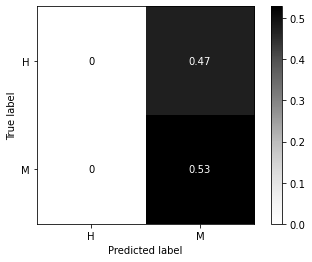

In [6]:
cm = confusion_matrix(y_test, y_pred.round(), normalize='all')
cm = ConfusionMatrixDisplay(cm, display_labels=['H','M'])
cm.plot(cmap='Greys')
plt.show()

The second baseline model we examine is a logistic regression on the Bleu score for each translation. This model does remarkably well!

In [13]:
logit = LogisticRegression()
logit.fit(X_baseline_train, y)
y_pred = logit.predict(X_baseline_test)
print(f"Logistic regression accuracy: {accuracy_score(y_test, y_pred):.2%}")
baseline = f1_score(y_test, y_pred, average='macro')
print(f"Logistic modified f1 score: {baseline:.3f}")

Logistic regression accuracy: 75.29%
Logistic modified f1 score: 0.752


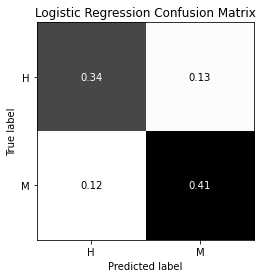

In [8]:
cm = confusion_matrix(y_test, y_pred.round(), normalize='all')
cm = ConfusionMatrixDisplay(cm, display_labels=['H','M'])
cm.plot(cmap='Greys', colorbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## LSTM Training

In [9]:
EPOCHS = 50
model = models.NN(embed_weights)
loader = models.get_loader(X, y)
#optimizer = torch.optim.SGD(model.parameters(), lr=.001)
optimizer = torch.optim.Adam(model.parameters())

In [10]:
train_loss = []
test_loss = []
test_f1 = []

model.train()
model.double()
model.to('cuda')

for e in tqdm(range(EPOCHS)):
    loss = models.train_epoch(model, loader, optimizer)

    y_pred, y_true = models.test_model(model, test_loader)
    
    y_pred_c = y_pred.argmax(axis=1).cpu()
    
    train_loss.append(loss)
    #test_loss.append(((y_pred - y_true)**2).mean())
    #test_acc.append((y_pred_c == y_true).float().mean())
    f1 = f1_score(y_true, y_pred_c.cpu()
    test_f1.append(f1, average='macro'))

    if f1 > baseline:
        break

100%|██████████| 50/50 [03:14<00:00,  3.90s/it]


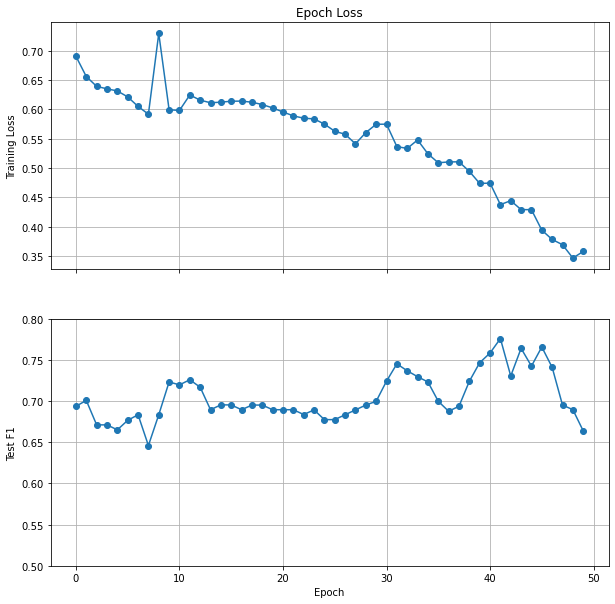

In [11]:
plt.subplots(2, 1, sharex=True, figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(range(len(train_loss)), train_loss, '-o', label="Training loss")
plt.grid()
#plt.xticks(range(len(l)))
plt.title("Epoch Loss")
plt.ylabel("Training Loss")

plt.subplot(2, 1, 2)
plt.plot(range(len(test_f1)), torch.tensor(test_f1), '-o', label="Test accuracy")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Test F1")
plt.ylim((0.5,0.80))
plt.show()


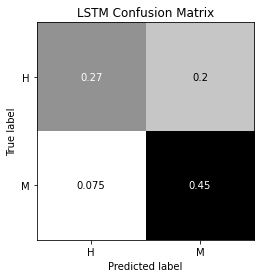

In [12]:
cm = confusion_matrix(y_true, y_pred_c.cpu(), normalize='all')
cm = ConfusionMatrixDisplay(cm, display_labels=['H','M'])
cm.plot(cmap='Greys', colorbar=False)
plt.title("LSTM Confusion Matrix")
plt.show()

In [13]:
print(f"Model f1 score: {f1_score(y_true, y_pred_c.cpu(), average='macro'):.3f}")

Model f1 score: 0.714
